# LSTM

In [28]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna
import joblib
import matplotlib.pyplot as plt

In [2]:
experiment_log = pd.DataFrame(columns=["Epochen", "Hidden_Size", "Num_Layers", "Final_Loss", "Learning_Rate", "MAE", "RMSE", "sMAPE", "MAE Original", "RMSE Original", "sMAPE Original"])

In [2]:
df = pd.read_pickle('df_neutor_features.pkl')

### Training und Test Daten

In [3]:
# Gesamtdatenmenge
data_size = len(df)

# Aufteilung in Trainings-, Validierungs- und Testsets
train_size = int(data_size * 0.7)  # 70% Training
test_size = int(data_size * 0.2)   # 20% Test
val_size = data_size - train_size - test_size  # Rest für die Validierung

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]
val_data = df.iloc[train_size+test_size:]

### Datum und Zeit spalten

In [4]:
def preprocess_data(data):
    X = data.drop(columns=["Neutor (gesamt)"])
    y = data["Neutor (gesamt)"]
    
    # "Zeit"-Spalte in datetime konvertieren
    X['Zeit'] = pd.to_datetime(X['Zeit'], format='%H:%M:%S')
    
    # Stunde und Minute extrahieren
    X['Stunde'] = X['Zeit'].dt.hour
    X['Minute'] = X['Zeit'].dt.minute
    
    # Datum zerlegen
    X['Jahr'] = X['Datum'].dt.year
    X['Monat'] = X['Datum'].dt.month
    X['Tag'] = X['Datum'].dt.day

    # One-Hot-Encoding für "Wochentag"
    X = pd.get_dummies(X, columns=['Wochentag'])
    X = pd.get_dummies(X, columns=['Jahreszeit'])

    # "Zeit" und "Datum" entfernen
    X = X.drop(columns=['Zeit', 'Datum'])

    return X, y

In [5]:
X_train, y_train = preprocess_data(train_data)
X_val, y_val = preprocess_data(val_data)
X_test, y_test = preprocess_data(test_data)

#### Visualisierung vom Split

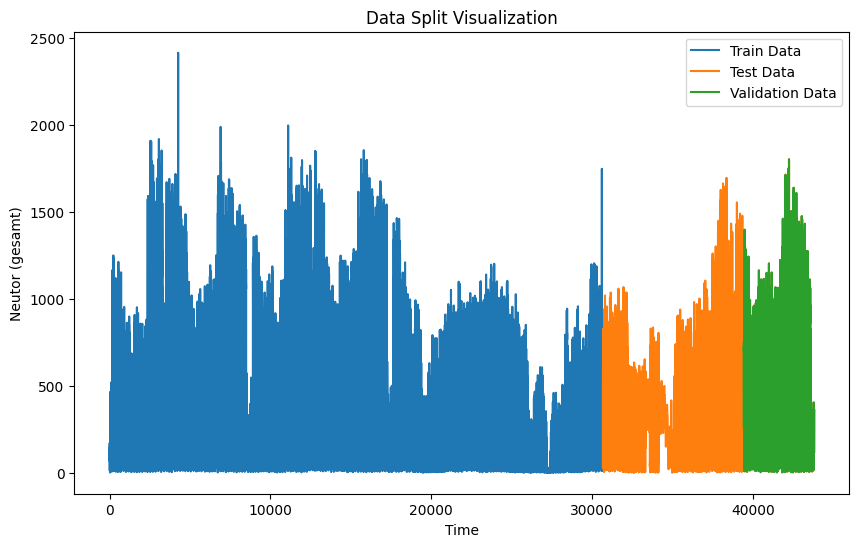

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(X_train.index, y_train, label="Train Data")
plt.plot(X_test.index, y_test, label="Test Data")
plt.plot(X_val.index, y_val, label="Validation Data")
plt.xlabel("Time")
plt.ylabel("Neutor (gesamt)")
plt.title("Data Split Visualization")
plt.legend()
plt.show()

In [8]:
columns_series = pd.Series(X_train.columns)

columns_series.to_csv('model_metadata/column_names.csv', index=False)

#### Test Daten enthalten nicht alle Jahreszeiten, da sie nur die letzten 20% vom Datensatz sind

In [6]:
all_seasons = set(X_train.columns)
missing_seasons_val = all_seasons - set(X_val.columns)
missing_seasons_test = all_seasons - set(X_test.columns)

for season in missing_seasons_val:
    X_val[season] = False

for season in missing_seasons_test:
    X_test[season] = False

In [9]:
# Merkmale und Zielvariable skalieren
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val = X_val[columns_series] # Reihenfolge der Spalten hat nicht gepasst
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [24]:
joblib.dump(scaler_X, 'scaler_lstm/scaler_X_lstm.pkl')
joblib.dump(scaler_y, 'scaler_lstm/scaler_y_lstm.pkl')

['scaler_lstm/scaler_y_lstm.pkl']

In [10]:
def create_sequences(data, target, sequence_length):
    sequences = []
    target_seq = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(seq)
        target_seq.append(label)
    
    return np.array(sequences), np.array(target_seq)

sequence_length = 10

X_train_sequence, y_train_sequence = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_sequence, y_test_sequence = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

In [11]:
X_train_sequence, y_train_sequence = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val_sequence, y_val_sequence = create_sequences(X_val_scaled, y_val_scaled, sequence_length)
X_test_sequence, y_test_sequence = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

In [12]:
X_train_tensor = torch.Tensor(X_train_sequence)
y_train_tensor = torch.Tensor(y_train_sequence)
X_val_tensor = torch.Tensor(X_val_sequence)
y_val_tensor = torch.Tensor(y_val_sequence)
X_test_tensor = torch.Tensor(X_test_sequence)
y_test_tensor = torch.Tensor(y_test_sequence)

##### Seed setzen für immer gleichen Ablauf

In [22]:
def set_seed(seed_value=42):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [14]:


def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Definieren des LSTM-Modells
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out[:, -1, :])
        return output

input_size = X_train_tensor.shape[2]  

def objective(trial):
    # Hyperparameter-Räume
    hidden_size = trial.suggest_int("hidden_size", 30, 80)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.009, log=True)
    epochs = trial.suggest_int("epochs", 50, 150)

    model = LSTMModel(input_size, hidden_size, num_layers)
    criterion = nn.MSELoss() # <- Hier ist der Fehler, hätte MAE sein muessen
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early Stopping Variablen
    patience = 20
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs): 
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Vorhersagen auf VAL Datensatz
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = mean_squared_error(y_val_tensor.numpy(), val_outputs.numpy())

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping after epoch {epoch}")
            break
    
    
    # Vorhersagen auf dem Testdatensatz
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predictions = predictions.numpy()
        y_test_np = y_test_tensor.numpy()

    # Metriken berechnen
    mae = np.mean(np.abs(predictions - y_test_np))
    rmse = np.sqrt(np.mean((predictions - y_test_np)**2))
    smape_met = smape(y_test_np, predictions)  

    # Vorhersagen zurücktransformieren
    predictions_original_scale = scaler_y.inverse_transform(predictions)
    y_test_original_scale = scaler_y.inverse_transform(y_test_np)

    # Metriken für zurücktransformierte Werte berechnen
    mae_original = np.mean(np.abs(predictions_original_scale - y_test_original_scale))
    rmse_original = np.sqrt(np.mean((predictions_original_scale - y_test_original_scale)**2))
    smape_original = smape(y_test_original_scale, predictions_original_scale)

    # Ergebnisse in den DataFrame speichern
    new_data = {
        "Epochen": trial.params["epochs"],
        "Hidden_Size": trial.params["hidden_size"],
        "Num_Layers": trial.params["num_layers"],
        "Final_Loss": val_loss,
        "Learning_Rate": trial.params["learning_rate"],
        "MAE": mae,
        "RMSE": rmse,
        "sMAPE": smape_met,
        "MAE Original": mae_original,
        "RMSE Original": rmse_original,
        "sMAPE Original": smape_original
    }
    
    experiment_log.loc[len(experiment_log)] = new_data

    columns_to_round = ["Final_Loss", "MAE", "RMSE", "sMAPE", "MAE Original", "RMSE Original", "sMAPE Original"]
    
    return val_loss

# Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, n_jobs=2) # Trails = Durchlaeufe, n_jobs = Parallel

# Beste Hyperparameter ausgeben
print(study.best_params)

[I 2023-08-30 15:40:51,181] A new study created in memory with name: no-name-c98c42a5-4b95-4ca7-b302-3a2f79203907
[I 2023-08-30 15:43:29,183] Trial 0 finished with value: 0.0017518464010208845 and parameters: {'hidden_size': 30, 'num_layers': 2, 'learning_rate': 0.007289269929347593, 'epochs': 112}. Best is trial 0 with value: 0.0017518464010208845.
[I 2023-08-30 15:44:42,365] Trial 1 finished with value: 0.0030233291909098625 and parameters: {'hidden_size': 37, 'num_layers': 3, 'learning_rate': 0.006515838657079318, 'epochs': 88}. Best is trial 0 with value: 0.0017518464010208845.


Early stopping after epoch 79


[I 2023-08-30 15:50:36,566] Trial 2 finished with value: 0.004978919867426157 and parameters: {'hidden_size': 70, 'num_layers': 3, 'learning_rate': 0.006546117204671558, 'epochs': 119}. Best is trial 0 with value: 0.0017518464010208845.
[I 2023-08-30 15:53:06,409] Trial 3 finished with value: 0.002560943365097046 and parameters: {'hidden_size': 69, 'num_layers': 3, 'learning_rate': 0.005972456636387436, 'epochs': 96}. Best is trial 0 with value: 0.0017518464010208845.
[I 2023-08-30 15:56:13,163] Trial 4 finished with value: 0.0029709464870393276 and parameters: {'hidden_size': 57, 'num_layers': 2, 'learning_rate': 0.006311251732092684, 'epochs': 139}. Best is trial 0 with value: 0.0017518464010208845.
[I 2023-08-30 15:57:53,079] Trial 5 finished with value: 0.0017719900934025645 and parameters: {'hidden_size': 46, 'num_layers': 2, 'learning_rate': 0.0076693848519409896, 'epochs': 138}. Best is trial 0 with value: 0.0017518464010208845.
[I 2023-08-30 16:00:26,232] Trial 7 finished with 

Early stopping after epoch 127


[I 2023-08-30 16:14:08,283] Trial 15 finished with value: 0.0027190973050892353 and parameters: {'hidden_size': 39, 'num_layers': 2, 'learning_rate': 0.007165328412106371, 'epochs': 133}. Best is trial 6 with value: 0.0016570460284128785.
[I 2023-08-30 16:17:11,796] Trial 16 finished with value: 0.0014111592900007963 and parameters: {'hidden_size': 38, 'num_layers': 2, 'learning_rate': 0.00704186840120911, 'epochs': 149}. Best is trial 16 with value: 0.0014111592900007963.
[I 2023-08-30 16:27:31,249] Trial 17 finished with value: 0.003243429586291313 and parameters: {'hidden_size': 80, 'num_layers': 3, 'learning_rate': 0.008670285928907886, 'epochs': 148}. Best is trial 16 with value: 0.0014111592900007963.
[I 2023-08-30 16:28:26,260] Trial 18 finished with value: 0.0018871796783059835 and parameters: {'hidden_size': 58, 'num_layers': 3, 'learning_rate': 0.008153254686619007, 'epochs': 149}. Best is trial 16 with value: 0.0014111592900007963.
[I 2023-08-30 16:29:27,699] Trial 19 finish

Early stopping after epoch 108


[I 2023-08-30 16:31:05,678] Trial 21 finished with value: 0.004581348970532417 and parameters: {'hidden_size': 35, 'num_layers': 2, 'learning_rate': 0.006903613288466656, 'epochs': 69}. Best is trial 16 with value: 0.0014111592900007963.
[I 2023-08-30 16:31:52,749] Trial 22 finished with value: 0.0013626565923914313 and parameters: {'hidden_size': 52, 'num_layers': 1, 'learning_rate': 0.008214817957608369, 'epochs': 149}. Best is trial 22 with value: 0.0013626565923914313.
[I 2023-08-30 16:33:08,106] Trial 23 finished with value: 0.002581481821835041 and parameters: {'hidden_size': 43, 'num_layers': 1, 'learning_rate': 0.008022858182792577, 'epochs': 144}. Best is trial 22 with value: 0.0013626565923914313.
[I 2023-08-30 16:33:48,588] Trial 24 finished with value: 0.002394135808572173 and parameters: {'hidden_size': 52, 'num_layers': 1, 'learning_rate': 0.007665806348750389, 'epochs': 131}. Best is trial 22 with value: 0.0013626565923914313.
[I 2023-08-30 16:35:19,482] Trial 25 finishe

Early stopping after epoch 120


[I 2023-08-30 16:53:29,365] Trial 32 finished with value: 0.002308689523488283 and parameters: {'hidden_size': 34, 'num_layers': 2, 'learning_rate': 0.0074481110140175765, 'epochs': 140}. Best is trial 22 with value: 0.0013626565923914313.
[I 2023-08-30 16:57:31,386] Trial 34 finished with value: 0.0023795890156179667 and parameters: {'hidden_size': 34, 'num_layers': 3, 'learning_rate': 0.0071807459821003755, 'epochs': 125}. Best is trial 22 with value: 0.0013626565923914313.
[I 2023-08-30 16:58:04,522] Trial 33 finished with value: 0.002290976233780384 and parameters: {'hidden_size': 35, 'num_layers': 3, 'learning_rate': 0.0073308061879074045, 'epochs': 140}. Best is trial 22 with value: 0.0013626565923914313.
[I 2023-08-30 17:01:36,420] Trial 36 finished with value: 0.002068862784653902 and parameters: {'hidden_size': 40, 'num_layers': 2, 'learning_rate': 0.00791372411368387, 'epochs': 143}. Best is trial 22 with value: 0.0013626565923914313.
[I 2023-08-30 17:02:32,924] Trial 35 fini

Early stopping after epoch 89
{'hidden_size': 52, 'num_layers': 1, 'learning_rate': 0.008214817957608369, 'epochs': 149}


In [15]:
print(study.best_params)
print(study.best_value)

{'hidden_size': 52, 'num_layers': 1, 'learning_rate': 0.008214817957608369, 'epochs': 149}
0.0013626565923914313


In [16]:
print(study.trials_dataframe())

    number     value             datetime_start          datetime_complete  \
0        0  0.001752 2023-08-30 15:40:51.182843 2023-08-30 15:43:29.182557   
1        1  0.003023 2023-08-30 15:40:51.183764 2023-08-30 15:44:42.365111   
2        2  0.004979 2023-08-30 15:43:29.193867 2023-08-30 15:50:36.562747   
3        3  0.002561 2023-08-30 15:44:42.374163 2023-08-30 15:53:06.405083   
4        4  0.002971 2023-08-30 15:50:36.572451 2023-08-30 15:56:13.161927   
5        5  0.001772 2023-08-30 15:53:06.427803 2023-08-30 15:57:53.078253   
6        6  0.001657 2023-08-30 15:56:13.176280 2023-08-30 16:01:45.779359   
7        7  0.002645 2023-08-30 15:57:53.090521 2023-08-30 16:00:26.232569   
8        8  0.003470 2023-08-30 16:00:26.235417 2023-08-30 16:03:19.265820   
9        9  0.003094 2023-08-30 16:01:45.793046 2023-08-30 16:06:25.399740   
10      10  0.004275 2023-08-30 16:03:19.271584 2023-08-30 16:08:19.377619   
11      11  0.004376 2023-08-30 16:06:25.404808 2023-08-30 16:06

In [27]:
experiment_log.to_csv('model_metadata/experiment_log_lstm.csv', index=False)

In [35]:
# Beste Hyperparameter aus Optuna
best_params = study.best_params
hidden_size_opt =  best_params["hidden_size"]
num_layers_opt =  best_params["num_layers"]
learning_rate_opt = best_params["learning_rate"]
epochs_opt = best_params["epochs"]

# Definieren LSTM-Modell
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out[:, -1, :])
        return output

input_size = X_train_tensor.shape[2]

# Model erzeugen
model = LSTMModel(input_size, hidden_size_opt, num_layers_opt)

# Verlustfunktion und Optimierer
criterion = nn.MSELoss() # <- Hier ist der Fehler, hätte MAE sein muessen
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_opt)

# Training und Validierungsverlust
train_losses = []
val_losses = []

# Training
for epoch in range(epochs_opt):
    # Vorwärtslauf
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Rückwärtslauf und Optimierung
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Trainingsverlust speichern
    train_losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs_opt}, Loss: {loss.item()}")

    # Validierung
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Validierungsverlust speichern
    val_losses.append(val_loss.item())

Epoch 0/149, Loss: 0.027071690186858177
Epoch 10/149, Loss: 0.010591068305075169
Epoch 20/149, Loss: 0.008137064054608345
Epoch 30/149, Loss: 0.0057817851193249226
Epoch 40/149, Loss: 0.0038211410865187645
Epoch 50/149, Loss: 0.0029366575181484222
Epoch 60/149, Loss: 0.0022683925926685333
Epoch 70/149, Loss: 0.0018356824293732643
Epoch 80/149, Loss: 0.0015229826094582677
Epoch 90/149, Loss: 0.001603865996003151
Epoch 100/149, Loss: 0.0013173219049349427
Epoch 110/149, Loss: 0.0010862585622817278
Epoch 120/149, Loss: 0.0011720729526132345
Epoch 130/149, Loss: 0.0010295378742739558
Epoch 140/149, Loss: 0.000937580072786659


In [28]:
df_best_params = pd.DataFrame([best_params])

# Speichern CSV-Datei
df_best_params.to_csv('model_metadata/best_params_lstm.csv', index=False)

In [20]:
# Vorhersagen auf dem Testdatensatz
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = predictions.numpy()
    y_test_np = y_test_tensor.numpy()

# MAE
mae = np.mean(np.abs(predictions - y_test_np))

# RMSE
rmse = np.sqrt(np.mean((predictions - y_test_np)**2))

# MAPE
smape_met = smape(y_test_np, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {smape_met}%")

# Vorhersagen zurücktransformieren
predictions_original_scale = scaler_y.inverse_transform(predictions)

# Tatsächliche Werte zurücktransformieren
y_test_original_scale = scaler_y.inverse_transform(y_test_np)

# Jetzt berechnen Sie die Metriken erneut mit den zurücktransformierten Werten
mae_original = np.mean(np.abs(predictions_original_scale - y_test_original_scale))
rmse_original = np.sqrt(np.mean((predictions_original_scale - y_test_original_scale)**2))
smape_original = smape(y_test_original_scale, predictions_original_scale)

print(f"Mean Absolute Error (MAE Original): {mae_original}")
print(f"Root Mean Squared Error (RMSE Original): {rmse_original}")
print(f"Mean Absolute Percentage Error (MAPE Original): {mape_original}%")

Mean Absolute Error (MAE): 0.03886103630065918
Root Mean Squared Error (RMSE): 0.05333328619599342
Mean Absolute Percentage Error (MAPE): 43.54620938832115%
Mean Absolute Error (MAE Original): 93.81053161621094
Root Mean Squared Error (RMSE Original): 128.74655151367188
Mean Absolute Percentage Error (MAPE Original): inf%


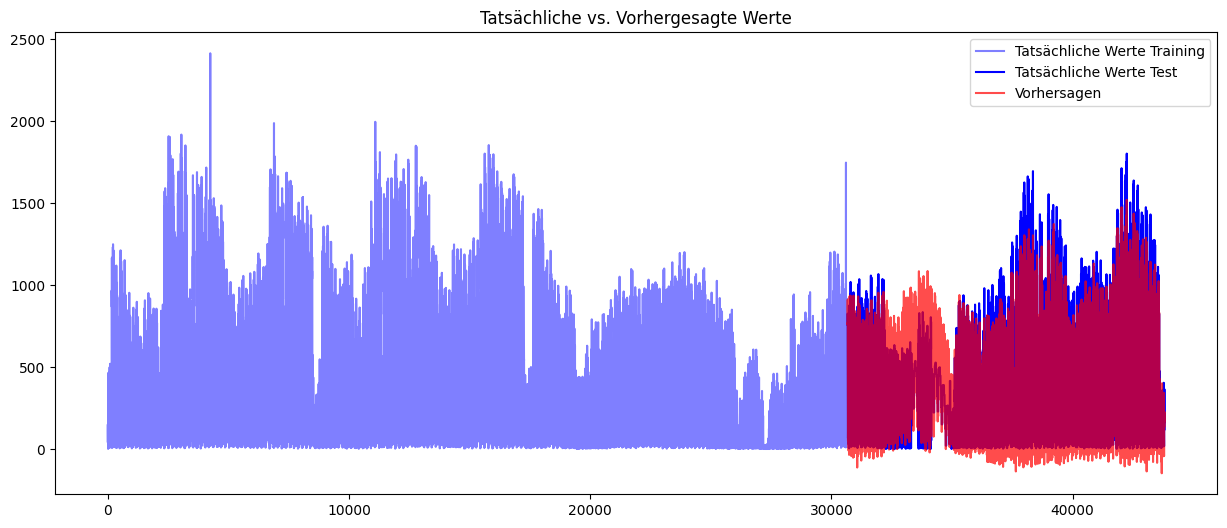

In [21]:
# Vorhersagen mit dem Modell
y_pred = model(X_test_tensor)
y_pred = y_pred.detach().numpy()

# Rücktransformation der Daten in den Originalmaßstab
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy())
y_train_original = scaler_y.inverse_transform(y_train_tensor.numpy())

# Visualisierung
plt.figure(figsize=(15, 6))

# Trainingsdaten in hellblau
plt.plot(y_train_original, label='Tatsächliche Werte Training', color='blue', alpha=0.5)

# Testdaten in dunkelblau
plt.plot(range(len(y_train_original) + sequence_length, len(y_train_original) + sequence_length + len(y_test_original)), y_test_original, label='Tatsächliche Werte Test', color='blue')

# Vorhersagen in rot
plt.plot(range(len(y_train_original) + sequence_length, len(y_train_original) + sequence_length + len(y_test_original)), y_pred_original, label='Vorhersagen', color='red', alpha=0.7)

plt.title('Tatsächliche vs. Vorhergesagte Werte')
plt.legend()
plt.show()

In [29]:
# Model speichern
torch.save(model.state_dict(), 'lstm_model_without_weather.pth')

### Overfitting test

[0.027071690186858177, 0.03845258802175522, 0.01680416613817215, 0.02027072198688984, 0.02020292542874813, 0.015191299840807915, 0.012535409070551395, 0.013734820298850536, 0.014226182363927364, 0.012430090457201004, 0.010591068305075169, 0.010041887871921062, 0.010401826351881027, 0.010589146055281162, 0.010058574378490448, 0.009215006604790688, 0.008757303468883038, 0.008864945732057095, 0.009013841859996319, 0.008716501295566559, 0.008137064054608345, 0.007703864015638828, 0.0075790658593177795, 0.00760548235848546, 0.0075325933285057545, 0.007243012543767691, 0.0068280817940831184, 0.006476487033069134, 0.006278643850237131, 0.006114657036960125, 0.0057817851193249226, 0.005313732661306858, 0.005045073106884956, 0.00501295318827033, 0.004716650117188692, 0.004492719192057848, 0.004467897582799196, 0.004154408350586891, 0.003973835147917271, 0.003987381234765053, 0.0038211410865187645, 0.0036562017630785704, 0.0036155886482447386, 0.003500411519780755, 0.003377396147698164, 0.003417

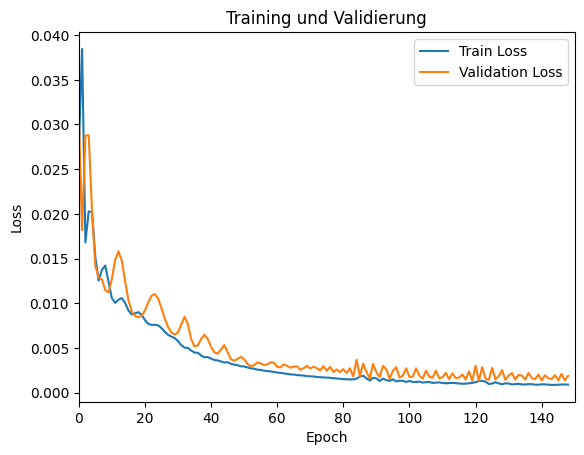

In [36]:
print(train_losses)
print(val_losses)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training und Validierung')
plt.legend()
plt.xlim(0, 150)

plt.savefig('visualization/mae_loss_lstm.png', bbox_inches='tight', dpi=1000)

plt.show()